# Project 3: `Web API's` & `Classification`
---
_Gabriel Perez Prieto_  

### 03_Modeling
---

#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Do not display future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set max_columns display to 500
pd.set_option('display.max_columns', 500)

#### Load Clean Data

In [3]:
df = pd.read_csv('./data/reddit_clean.csv')

In [4]:
# Check shape
df.shape

(9664, 9)

In [5]:
df.head(1)

,author,body,score,subreddit,created_date,target,tokens,avg_word_len,num_words
0,ThisIsMyRental,"My, my, my, you've outdone yourself friend! It...",1,vegan,2019-10-17 20:01:40,1,"['My', 'my', 'my', 'you', 've', 'outdone', 'yo...",4.266667,15


In [4]:
# Duplciate DataFrame to be used as model1
df_model_1 = df

#### Create Classes to Lemmatize / Stem Text 

In [5]:
# Create classes to be used on pipeline / randomsearchCV
class Lemmatizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        tokenizer = RegexpTokenizer('(?u)\\b\\w\\w+\\b')
        return [self.wnl.lemmatize(t) for t in tokenizer.tokenize(doc)]

class Stemmer(object):
    def __init__(self):
        self.wnl = PorterStemmer()
    def __call__(self, doc):
        tokenizer = RegexpTokenizer('(?u)\\b\\w\\w+\\b')
        return [self.wnl.stem(t) for t in tokenizer.tokenize(doc)]
    
# Adapted from:
# https://stackoverflow.com/questions/23980755/scikit-learn-grid-search-with-custom-countvectorizer-tokenizer

#### Define X ( features ) and y ( target )

In [6]:
X = df_model_1[['body', 'avg_word_len', 'num_words']]
y = df_model_1['target']

#### Establishing Baseline Score - Compare to Models Created

In [7]:
# 50.04% Accuracy
y.value_counts(normalize=True)

1    0.500414
0    0.499586
Name: target, dtype: float64

#### Train Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify=y,
                                                    test_size = 0.25)

### Section 1 - Set up Pipelines for Different Models  to be Tested
---

#### Pipelines w/ Classifiers and Transformers

#### Set up Pipelines w/ CountVectorizer

In [21]:
# CountVectorizer + LogisticRegression (1.1)
pipe_cvec_logreg = Pipeline([
    ('ct', ColumnTransformer([('cvec', CountVectorizer(), 'body')])),  # Instantiate transformer
    ('logreg', LogisticRegression()),                                  # Instantiante estimator
])

# CountVectorizer + K Nearest Neighbor (1.2)
pipe_cvec_knn = Pipeline([             
    ('ct', ColumnTransformer([('cvec', CountVectorizer(), 'body')])),  # Instantiate transformer
    ('knn', KNeighborsClassifier())                                    # Instantiante estimator
])

# CountVectorizer + Naive Bayes (1.3)
pipe_cvec_mnb = Pipeline([             
    ('ct', ColumnTransformer([('cvec', CountVectorizer(), 'body')])),  # Instantiate transformer
    ('mnb', MultinomialNB())                                           # Instantiante estimator
])

# CountVectorizer + Decision Tree (1.4)
pipe_cvec_dt = Pipeline([              
    ('ct', ColumnTransformer([('cvec', CountVectorizer(), 'body')])),  # Instantiate transformer
    ('dt', DecisionTreeClassifier())                                   # Instantiante estimator
])

# CountVectorizer + Random Forest (1.5)      
pipe_cvec_rf = Pipeline([ 
('ct', ColumnTransformer([('cvec', CountVectorizer(), 'body')])),      # Instantiate transformer
('rf', RandomForestClassifier())                                       # Instantiante estimator
])

# CountVectorizer + Suported Vector Classifier (1.6) 
pipe_cvec_svc = Pipeline([ 
('ct', ColumnTransformer([('cvec', CountVectorizer(), 'body')])),      # Instantiate transformer
('svc', SVC())                                                         # Instantiante estimator
])

#### Set up Pipelines w/ TfidfVectorizer

In [32]:
# TfidfVectorizer + LogisticRegression (2.1)
pipe_tfidf_logreg = Pipeline([         
    ('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'body')])), # Instantiate transformer
    ('logreg', LogisticRegression())                                   # Instantiante estimator
])

# TfidfVectorizer + K Nearest Neighbor (2.2)
pipe_tfidf_knn = Pipeline([            
    ('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'body')])), # Instantiate transformer
    ('knn', KNeighborsClassifier())                                    # Instantiante estimator
])

# TfidfVectorizer + Naive Bayes (2.3)
pipe_tfidf_mnb = Pipeline([            
    ('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'body')])), # Instantiate transformer
    ('mnb', MultinomialNB())                                           # Instantiante estimator
])

# TfidfVectorizer + Decision Tree (2.4)
pipe_tfidf_dt = Pipeline([             
    ('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'body')])), # Instantiate transformer
    ('dt', DecisionTreeClassifier())                                   # Instantiante estimator
])

# TfidfVectorizer + Random Forest (2.5)      
pipe_tfidf_rf = Pipeline([ 
('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'body')])),     # Instantiate transformer
('rf', RandomForestClassifier())                                       # Instantiante estimator
])  

# TfidfVectorizer + Suported Vector Classifier (2.6) 
pipe_tfidf_svc = Pipeline([ 
('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'body')])),      # Instantiate transformer
('svc', SVC())                                                         # Instantiante estimator
])

#### Set up parameters for GridSearchCV, RandomizedSearchCV ( Count Vectorizer )

In [23]:
params_cvec_logreg = {
    'ct__cvec__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__cvec__max_features' : [1500, 2000, 2500],
    'ct__cvec__stop_words': ['english', None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [.85, 0.9, 0.95],
    'ct__cvec__min_df': [1, 2, 3, 4],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.01, 0.1, 1],
}

params_cvec_knn = {
    'ct__cvec__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__cvec__max_features' : [1500, 2000, 2500],
    'ct__cvec__stop_words': ['english', None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [.85, 0.9, 0.95],
    'ct__cvec__min_df': [1, 2, 3, 4],
    'knn__n_neighbors': [5, 7],
    'knn__p': [2]
}

params_cvec_mnb = {
    'ct__cvec__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__cvec__max_features' : [1500, 2000, 2500],
    'ct__cvec__stop_words': ['english', None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [.85, 0.9, 0.95],
    'ct__cvec__min_df': [1, 2, 3, 4],
    'mnb__alpha': [1, .9, .8],
}

params_cvec_dt = {
    'ct__cvec__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__cvec__max_features' : [1500, 2000, 2500],
    'ct__cvec__stop_words': ['english', None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [.85, 0.9, 0.95],
    'ct__cvec__min_df': [1, 2, 3, 4],
    'dt__max_depth' : [3, 4],
    'dt__min_samples_split': [2, 3],
    'dt__min_samples_leaf': [2 ,3]
}

params_cvec_rf = {
    'ct__cvec__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__cvec__max_features' : [1500, 2000, 2500],
    'ct__cvec__stop_words': ['english', None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [.85, 0.9, 0.95],
    'ct__cvec__min_df': [1, 2, 3, 4],
    'rf__max_depth' : [3, 4],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [2, 3],
    'rf__n_estimators': [6, 10],
    'rf__max_features': [None, 3, 4]
}

params_cvec_svc = {
    'ct__cvec__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__cvec__max_features' : [1500, 2000, 2500],
    'ct__cvec__stop_words': ['english', None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [.85, 0.9, 0.95],
    'ct__cvec__min_df': [1, 2, 3, 4],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__C': np.logspace(-2, 1, 30)
}

#### Set up parameters for GridSearchCV, RandomizedSearchCV ( Tfidf Vectorizer )

In [24]:
params_tfidf_logreg = {
    'ct__tfidf__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__tfidf__max_features' : [1500, 2000, 2500],
    'ct__tfidf__stop_words': ['english', None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [.85, 0.9, 0.95],
    'ct__tfidf__min_df': [1, 2, 3, 4],
    'logreg__penalty': ['l2'],
    'logreg__C': [0.01, 0.1],
}

params_tfidf_knn = {
    'ct__tfidf__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__tfidf__max_features' : [1500, 2000, 2500],
    'ct__tfidf__stop_words': ['english', None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [.85, 0.9, 0.95],
    'ct__tfidf__min_df': [1, 2, 3, 4],
    'knn__n_neighbors': [3, 5, 7],
    'knn__p': [1, 2]
}

params_tfidf_mnb = {
    'ct__tfidf__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__tfidf__max_features' : [1500, 2000, 2500],
    'ct__tfidf__stop_words': ['english', None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [.85, 0.9, 0.95],
    'ct__tfidf__min_df': [1, 2, 3, 4],
    'mnb__alpha': [1, .9, .8]
}

params_tfidf_dt = {
    'ct__tfidf__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__tfidf__max_features' : [1500, 2000, 2500],
    'ct__tfidf__stop_words': ['english', None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [.85, 0.9, 0.95],
    'ct__tfidf__min_df': [1, 2, 3, 4],
    'dt__max_depth' : [3, 4],
    'dt__min_samples_split': [2, 3],
    'dt__min_samples_leaf': [2, 3]
}

params_tfidf_rf = {
    'ct__tfidf__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__tfidf__max_features' : [1500, 2000, 2500],
    'ct__tfidf__stop_words': ['english', None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [.85, 0.9, 0.95],
    'ct__tfidf__min_df': [1, 2, 3, 4],
    'rf__max_depth' : [3, 4],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [2, 3],
    'rf__n_estimators': [6, 10],
    'rf__max_features': [None, 3, 4]
}

params_tfidf_svc = {
    'ct__tfidf__tokenizer': [Lemmatizer(), Stemmer(), None],
    'ct__tfidf__max_features' : [1500, 2000, 2500],
    'ct__tfidf__stop_words': ['english', None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [.85, 0.9, 0.95],
    'ct__tfidf__min_df': [1, 2, 3, 4],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__C': np.logspace(-2, 1, 30)
}

In [13]:
# Instantiate a dictionary to house Models' Scores
results = {}

#### Function to Run All Different Models and Print Results

In [14]:
# Define function to run Pipeline + RandomizedSearchCV
def run_model_rs(pipeline, parameters, cv=3, model_name=''):
    
    # Instantiate RandomizedSearchCV
    rs = RandomizedSearchCV(pipeline,
                            parameters,
                            cv=cv,
                            verbose=1,
                            n_jobs=-1,
                            n_iter=20)
       
    # Fit GridSearch to training data
    rs.fit(X_train, y_train)
    
    # Best mean score out of cross validation out of all models tested (cvec)
    print(f'Best Score: {rs.best_score_}')
    
    # Best Paramenters
    print(f'Best Parameters: {rs.best_params_}')
    
    # Save best model as gs_cvec_logreg_model
    rs_model = rs.best_estimator_
    
    # Score model on training set.
    print(f'Training Accuracy Score: {rs_model.score(X_train, y_train)}')
    
    # Score model on testing set.
    print(f'Testing Accuracy Score: {rs_model.score(X_test, y_test)}')
    
    # Predictions
    pred = rs_model.predict(X_test)
    
    # Confusion Matrix
    cm_df = pd.DataFrame(confusion_matrix(y_test, pred),
                         columns=['pred_vegetarian', 'pred_vegan'],
                         index=['actual_vegetarian', 'actual_vegan'])
    print('Confusion Matrix:')
    print(cm_df)
    print(' ')
    
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    # Print different metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f'Accuracy: {accuracy}')
    
    misclassification = 1 - accuracy
    print(f'Misclassification: {misclassification}') 
    
    sensitivity = tp / (tp + fn)
    print(f'Sensitivity: {sensitivity}')
    
    specificity = tn / (tn + fp)
    print(f'Specificity: {specificity}')
    
    precision = tp / (tp + fp)
    print(f'Precision: {precision}')
    
    # 'Append' accuracy scores to 'results' dictinoary
    results[model_name] = [rs_model.score(X_train, y_train), rs_model.score(X_test, y_test),
                           misclassification, sensitivity, specificity, precision]

#### ( 1.1 ) CountVectorizer + LogisticRegression

In [15]:
run_model_rs(pipe_cvec_logreg, params_cvec_logreg, cv=3, model_name='cvec_logreg')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished


Best Score: 0.7004690949227373
Best Parameters: {'logreg__penalty': 'l2', 'logreg__C': 0.01, 'ct__cvec__tokenizer': <__main__.Lemmatizer object at 0x1096fbed0>, 'ct__cvec__stop_words': None, 'ct__cvec__ngram_range': (1, 1), 'ct__cvec__min_df': 3, 'ct__cvec__max_features': 1500, 'ct__cvec__max_df': 0.9}
Training Accuracy Score: 0.7393763796909493
Testing Accuracy Score: 0.7135761589403974
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian              826         381
actual_vegan                   311         898
 
Accuracy: 0.7135761589403974
Misclassification: 0.2864238410596026
Sensitivity: 0.7427626137303557
Specificity: 0.6843413421706711
Precision: 0.7021110242376857


#### ( 1.2 ) CountVectorizer + K Nearest Neighbor

In [16]:
run_model_rs(pipe_cvec_knn, params_cvec_knn, cv=3, model_name='cvec_knn')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'fo

Best Score: 0.6018211920529801
Best Parameters: {'knn__p': 2, 'knn__n_neighbors': 7, 'ct__cvec__tokenizer': <__main__.Stemmer object at 0x10970a090>, 'ct__cvec__stop_words': 'english', 'ct__cvec__ngram_range': (1, 1), 'ct__cvec__min_df': 1, 'ct__cvec__max_features': 2000, 'ct__cvec__max_df': 0.85}
Training Accuracy Score: 0.7221302428256071
Testing Accuracy Score: 0.5951986754966887
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian              600         607
actual_vegan                   371         838
 
Accuracy: 0.5951986754966887
Misclassification: 0.4048013245033113
Sensitivity: 0.6931348221670802
Specificity: 0.4971002485501243
Precision: 0.5799307958477509


#### ( 1.3 ) CountVectorizer + Naive Bayes

In [17]:
run_model_rs(pipe_cvec_mnb, params_cvec_mnb, cv=3, model_name='cvec_mnb')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.0min finished
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 

Best Score: 0.7137141280353201
Best Parameters: {'mnb__alpha': 0.9, 'ct__cvec__tokenizer': <__main__.Stemmer object at 0x10970a190>, 'ct__cvec__stop_words': 'english', 'ct__cvec__ngram_range': (1, 1), 'ct__cvec__min_df': 2, 'ct__cvec__max_features': 2500, 'ct__cvec__max_df': 0.95}
Training Accuracy Score: 0.7501379690949227
Testing Accuracy Score: 0.7222682119205298
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian              840         367
actual_vegan                   304         905
 
Accuracy: 0.7222682119205298
Misclassification: 0.2777317880794702
Sensitivity: 0.7485525227460711
Specificity: 0.695940347970174
Precision: 0.7114779874213837


#### ( 1.4 ) CountVectorizer + Decision Tree

In [18]:
run_model_rs(pipe_cvec_dt, params_cvec_dt, cv=3, model_name='cvec_dt')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.9min finished


Best Score: 0.6116169977924945
Best Parameters: {'dt__min_samples_split': 2, 'dt__min_samples_leaf': 2, 'dt__max_depth': 4, 'ct__cvec__tokenizer': <__main__.Stemmer object at 0x10970a2d0>, 'ct__cvec__stop_words': None, 'ct__cvec__ngram_range': (1, 3), 'ct__cvec__min_df': 2, 'ct__cvec__max_features': 1500, 'ct__cvec__max_df': 0.95}
Training Accuracy Score: 0.6128587196467992
Testing Accuracy Score: 0.6043046357615894
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian             1104         103
actual_vegan                   853         356
 
Accuracy: 0.6043046357615894
Misclassification: 0.39569536423841056
Sensitivity: 0.2944582299421009
Specificity: 0.9146644573322287
Precision: 0.775599128540305


#### ( 1.5 ) CountVectorizer + Random Forest

In [19]:
run_model_rs(pipe_cvec_rf, params_cvec_rf, cv=3, model_name='cvec_rf')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.0min finished


Best Score: 0.6492825607064018
Best Parameters: {'rf__n_estimators': 10, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 3, 'rf__max_features': None, 'rf__max_depth': 4, 'ct__cvec__tokenizer': <__main__.Stemmer object at 0x10970a3d0>, 'ct__cvec__stop_words': None, 'ct__cvec__ngram_range': (1, 2), 'ct__cvec__min_df': 4, 'ct__cvec__max_features': 1500, 'ct__cvec__max_df': 0.95}
Training Accuracy Score: 0.6216887417218543
Testing Accuracy Score: 0.6125827814569537
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian              332         875
actual_vegan                    61        1148
 
Accuracy: 0.6125827814569537
Misclassification: 0.38741721854304634
Sensitivity: 0.9495450785773366
Specificity: 0.2750621375310688
Precision: 0.5674740484429066


#### ( 1.6 ) CountVectorizer + Support Vector Classifier

In [25]:
run_model_rs(pipe_cvec_svc, params_cvec_svc, cv=3, model_name='cvec_svc')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.5min finished
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'fo

Best Score: 0.7000551876379691
Best Parameters: {'svc__kernel': 'linear', 'svc__C': 0.06723357536499334, 'ct__cvec__tokenizer': <__main__.Stemmer object at 0x10970a250>, 'ct__cvec__stop_words': 'english', 'ct__cvec__ngram_range': (1, 2), 'ct__cvec__min_df': 3, 'ct__cvec__max_features': 2500, 'ct__cvec__max_df': 0.9}
Training Accuracy Score: 0.8013245033112583
Testing Accuracy Score: 0.7168874172185431
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian              769         438
actual_vegan                   246         963
 
Accuracy: 0.7168874172185431
Misclassification: 0.2831125827814569
Sensitivity: 0.7965260545905707
Specificity: 0.6371168185584093
Precision: 0.6873661670235546


---

#### ( 2.1 ) TfidfVectorizer + LogisticRegression

In [26]:
run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, cv=3, model_name='tfidf_logreg')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 

Best Score: 0.7222682119205298
Best Parameters: {'logreg__penalty': 'l2', 'logreg__C': 0.1, 'ct__tfidf__tokenizer': <__main__.Stemmer object at 0x1a2404cfd0>, 'ct__tfidf__stop_words': 'english', 'ct__tfidf__ngram_range': (1, 2), 'ct__tfidf__min_df': 2, 'ct__tfidf__max_features': 2000, 'ct__tfidf__max_df': 0.95}
Training Accuracy Score: 0.76310706401766
Testing Accuracy Score: 0.7400662251655629
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian              844         363
actual_vegan                   265         944
 
Accuracy: 0.7400662251655629
Misclassification: 0.25993377483443714
Sensitivity: 0.7808105872622002
Specificity: 0.6992543496271748
Precision: 0.722264728385616


#### ( 2.2 ) TfidfVectorizer + K Nearest Neighbor

In [27]:
run_model_rs(pipe_tfidf_knn, params_tfidf_knn, cv=3, model_name='tfidf_knn')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.9min finished
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 

Best Score: 0.5407008830022075
Best Parameters: {'knn__p': 2, 'knn__n_neighbors': 3, 'ct__tfidf__tokenizer': <__main__.Stemmer object at 0x1097078d0>, 'ct__tfidf__stop_words': 'english', 'ct__tfidf__ngram_range': (1, 3), 'ct__tfidf__min_df': 4, 'ct__tfidf__max_features': 2000, 'ct__tfidf__max_df': 0.95}
Training Accuracy Score: 0.9115618101545254
Testing Accuracy Score: 0.5422185430463576
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian             1001         206
actual_vegan                   900         309
 
Accuracy: 0.5422185430463576
Misclassification: 0.45778145695364236
Sensitivity: 0.2555831265508685
Specificity: 0.8293289146644574
Precision: 0.6


#### ( 2.3 ) TfidfVectorizer + Naive Bayes

In [28]:
run_model_rs(pipe_tfidf_mnb, params_tfidf_mnb, cv=3, model_name='tfidf_mnb')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


Best Score: 0.7092991169977925
Best Parameters: {'mnb__alpha': 0.9, 'ct__tfidf__tokenizer': None, 'ct__tfidf__stop_words': 'english', 'ct__tfidf__ngram_range': (1, 1), 'ct__tfidf__min_df': 4, 'ct__tfidf__max_features': 2500, 'ct__tfidf__max_df': 0.9}
Training Accuracy Score: 0.7775938189845475
Testing Accuracy Score: 0.7177152317880795
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian              860         347
actual_vegan                   335         874
 
Accuracy: 0.7177152317880795
Misclassification: 0.2822847682119205
Sensitivity: 0.7229114971050455
Specificity: 0.7125103562551781
Precision: 0.7158067158067158


#### ( 2.4 ) TfidfVectorizer + Decision Tree

In [29]:
run_model_rs(pipe_tfidf_dt, params_tfidf_dt, cv=3, model_name='tfidf_dt')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


Best Score: 0.6085816777041942
Best Parameters: {'dt__min_samples_split': 2, 'dt__min_samples_leaf': 2, 'dt__max_depth': 4, 'ct__tfidf__tokenizer': <__main__.Stemmer object at 0x109707b10>, 'ct__tfidf__stop_words': None, 'ct__tfidf__ngram_range': (1, 2), 'ct__tfidf__min_df': 4, 'ct__tfidf__max_features': 2000, 'ct__tfidf__max_df': 0.95}
Training Accuracy Score: 0.6149282560706402
Testing Accuracy Score: 0.6047185430463576
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian             1100         107
actual_vegan                   848         361
 
Accuracy: 0.6047185430463576
Misclassification: 0.39528145695364236
Sensitivity: 0.2985938792390405
Specificity: 0.9113504556752279
Precision: 0.7713675213675214


#### ( 2.5 ) TfidfVectorizer + Random Forest

In [30]:
run_model_rs(pipe_tfidf_rf, params_tfidf_rf, cv=3, model_name='tfidf_rf')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 

Best Score: 0.6215507726269316
Best Parameters: {'rf__n_estimators': 10, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 3, 'rf__max_features': None, 'rf__max_depth': 3, 'ct__tfidf__tokenizer': <__main__.Stemmer object at 0x109707c10>, 'ct__tfidf__stop_words': 'english', 'ct__tfidf__ngram_range': (1, 3), 'ct__tfidf__min_df': 3, 'ct__tfidf__max_features': 1500, 'ct__tfidf__max_df': 0.9}
Training Accuracy Score: 0.6204470198675497
Testing Accuracy Score: 0.6125827814569537
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian              331         876
actual_vegan                    60        1149
 
Accuracy: 0.6125827814569537
Misclassification: 0.38741721854304634
Sensitivity: 0.9503722084367245
Specificity: 0.2742336371168186
Precision: 0.5674074074074074


#### ( 2.6 ) TfidfVectorizer + Support Vector Classifier

In [33]:
run_model_rs(pipe_tfidf_svc, params_tfidf_svc, cv=3, model_name='tfidf_svc')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.8min finished


Best Score: 0.7110927152317881
Best Parameters: {'svc__kernel': 'linear', 'svc__C': 0.02592943797404667, 'ct__tfidf__tokenizer': None, 'ct__tfidf__stop_words': 'english', 'ct__tfidf__ngram_range': (1, 2), 'ct__tfidf__min_df': 3, 'ct__tfidf__max_features': 2500, 'ct__tfidf__max_df': 0.95}
Training Accuracy Score: 0.7258554083885209
Testing Accuracy Score: 0.7181291390728477
Confusion Matrix:
                   pred_vegetarian  pred_vegan
actual_vegetarian              723         484
actual_vegan                   197        1012
 
Accuracy: 0.7181291390728477
Misclassification: 0.2818708609271523
Sensitivity: 0.837055417700579
Specificity: 0.5990057995028998
Precision: 0.6764705882352942


### Section 2 - Select Best Model
---

In [34]:
# DataFrame with Results
results_df = pd.DataFrame(results, index=['train', 'test', 'misclassification',
                             'sensitivity', 'specificity', 'precision']).T

results_df

,train,test,misclassification,sensitivity,specificity,precision
cvec_logreg,0.739376,0.713576,0.286424,0.742763,0.684341,0.702111
cvec_knn,0.722130,0.595199,0.404801,0.693135,0.497100,0.579931
cvec_mnb,0.750138,0.722268,0.277732,0.748553,0.695940,0.711478
cvec_dt,0.612859,0.604305,0.395695,0.294458,0.914664,0.775599
cvec_rf,0.621689,0.612583,0.387417,0.949545,0.275062,0.567474
cvec_svc,0.801325,0.716887,0.283113,0.796526,0.637117,0.687366
tfidf_logreg,0.763107,0.740066,0.259934,0.780811,0.699254,0.722265
tfidf_knn,0.911562,0.542219,0.457781,0.255583,0.829329,0.600000
tfidf_mnb,0.777594,0.717715,0.282285,0.722911,0.712510,0.715807
tfidf_dt,0.614928,0.604719,0.395281,0.298594,0.911350,0.771368


#### Plots for Scores

In [35]:
# Set plot style
plt.style.use('seaborn-darkgrid')

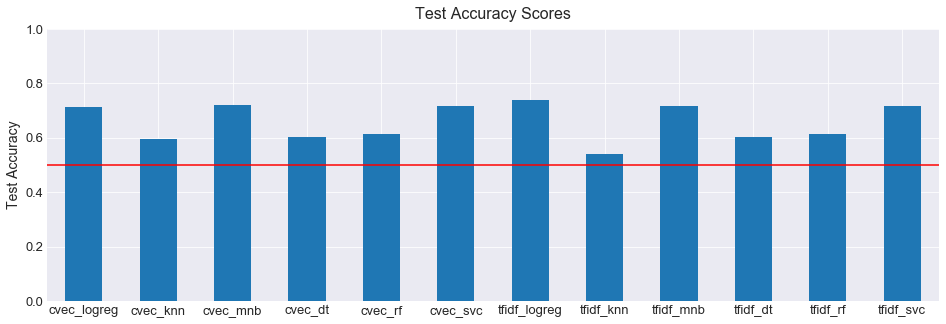

In [36]:
# Create plot fot 'Test Accuracy Scores'
results_df['test'].plot(kind='bar', figsize=(16,5))

plt.title('Test Accuracy Scores', size=16, pad=10)
plt.axhline(0.5, color='r')
plt.ylabel('Test Accuracy', size=14)
plt.xticks(size=13, rotation=0)
plt.yticks(size=13)
plt.ylim(0, 1);

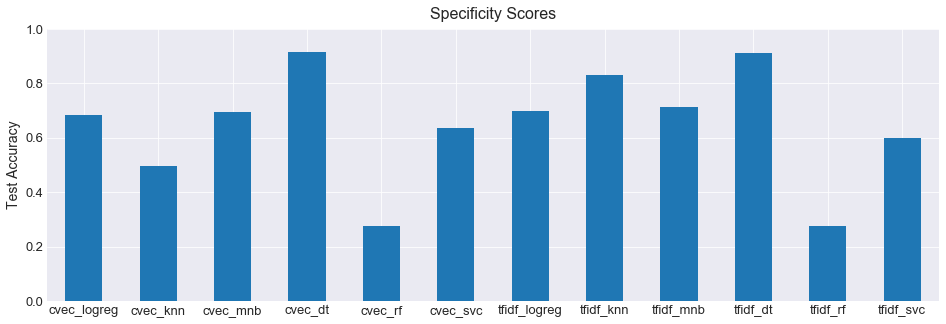

In [37]:
# Create plot fot 'Specificity Scores'
results_df['specificity'].plot(kind='bar', figsize=(16,5))

plt.title('Specificity Scores', size=16, pad=10)

plt.ylabel('Test Accuracy', size=14)
# plt.annotate()
plt.xticks(size=13, rotation=0)
plt.yticks(size=13)
plt.ylim(0,1);

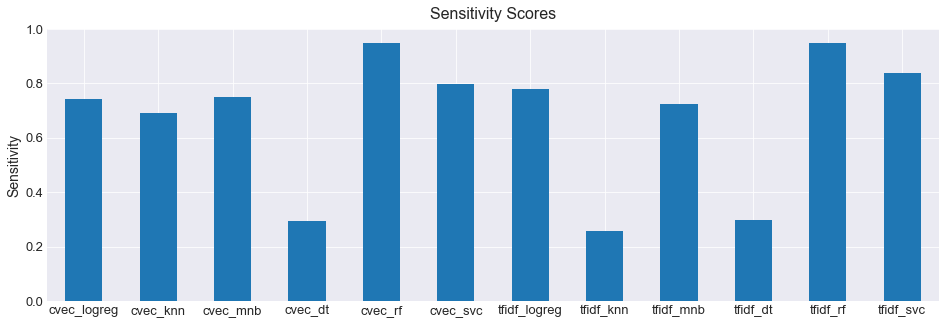

In [38]:
# Create plot fot 'Sensitivity Scores'
results_df['sensitivity'].plot(kind='bar', figsize=(16,5))

plt.title('Sensitivity Scores', size=16, pad=10)

plt.ylabel('Sensitivity', size=14)
plt.xticks(size=13, rotation=0)
plt.yticks(size=13)
plt.ylim(0,1);

### Results
---

#### Parameters to Select Best Model:
- Accuracy Score
- Interpretability

#### Chosen Model: tfidf_logreg ( TfidfVectorizer + Logistic Regression )

In [39]:
# Set Best Pipeline
pipeline = Pipeline([         
    ('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'body')])), # Instantiate transformer
    ('logreg', LogisticRegression())                                   # Instantiante estimator
])

In [40]:
# Set Best Parameters
parameters = {
    'ct__tfidf__tokenizer': [Stemmer()],
    'ct__tfidf__max_features' : [2000],
    'ct__tfidf__stop_words': ['english'],
    'ct__tfidf__ngram_range': [(1,2)],
    'ct__tfidf__max_df': [0.95],
    'ct__tfidf__min_df': [2],
    'logreg__penalty': ['l2'],
    'logreg__C': [0.1],
}

In [41]:
# Instantiate RandomizedSearchCV
rs = RandomizedSearchCV(pipeline,
                        parameters,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=20)

# Fit RandomSearch to training data
rs.fit(X_train, y_train)

# Predictions
pred = rs.predict(X_test)

/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.9s finished
/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whene

In [42]:
# Confusion Matrix
cm_df = pd.DataFrame(confusion_matrix(y_test, pred),
                     columns=['pred_vegetarian', 'pred_vegan'],
                     index=['actual_vegetarian', 'actual_vegan'])
print('Confusion Matrix:')
cm_df

Confusion Matrix:


,pred_vegetarian,pred_vegan
actual_vegetarian,844,363
actual_vegan,265,944


#### Most Frequent Words for Each Category ( PorterStemmer )

In [71]:
# Use Porter Stemmer to Tokenize and Get Most Common Words
tfidf = TfidfVectorizer(tokenizer=Stemmer(),
                        max_features=2000,
                        stop_words='english',
                        ngram_range=(1,2),
                        max_df=0.95,
                        min_df=2)

sparse_tfidf = tfidf.fit_transform(X_test['body'])

sparse_tfidf_df = pd.DataFrame(sparse_tfidf.toarray(),
                         columns=tfidf.get_feature_names())

sparse_tfidf_df['preds'] = rs.predict(X_test)

/Users/gabrielperezprieto/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not i

In [72]:
# Vegan Most Common words (Top 10)
vegan_words = pd.DataFrame(sparse_tfidf_df.loc[sparse_tfidf_df['preds']==1, :].sum().sort_values(ascending=False),
             columns=['word_count_stemm'])[1:11]

In [73]:
# Vegetarian Most Common words (Top 10)
vegetarian_words = pd.DataFrame(sparse_tfidf_df.loc[sparse_tfidf_df['preds']==0, :].sum().sort_values(ascending=False),
             columns=['word_count_stemm'])[:10]

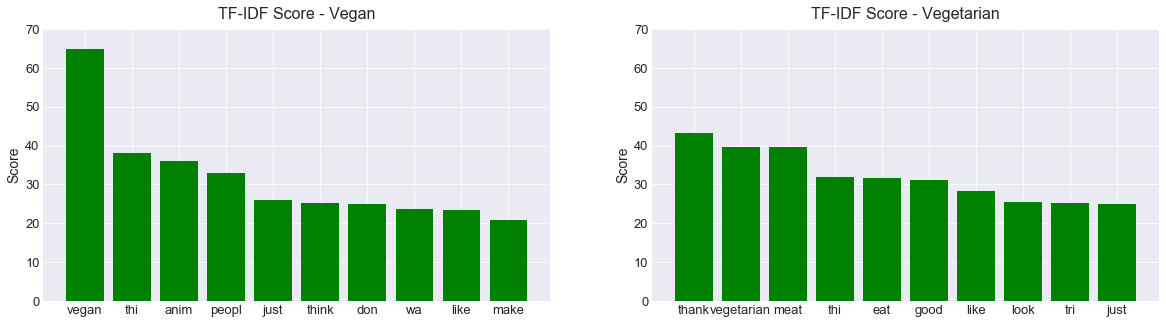

In [159]:
# Plot Most Common Words (Stemmer)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].bar(vegan_words.index, height=vegan_words['word_count_stemm'], color='green')
axes[0].set_title('TF-IDF Score - Vegan', size=16, pad=10)
axes[0].set_ylabel('Score', size=14)
axes[0].tick_params(labelsize=13)
axes[0].set_ylim(0,70)

axes[1].bar(vegetarian_words.index, height=vegetarian_words['word_count_stemm'], color='green')
axes[1].set_title('TF-IDF Score - Vegetarian', size=16, pad=10)
axes[1].set_ylabel('Score', size=14)
axes[1].tick_params(labelsize=13)
axes[1].set_ylim(0,70);

#### Most Frequent Words for Each Category ( Lemmatizer )

In [92]:
# Use Porter Stemmer to Tokenize and Get Most Common Words
tfidf = TfidfVectorizer(tokenizer=Lemmatizer(),
                        max_features=2000,
                        stop_words='english',
                        ngram_range=(1,2),
                        max_df=0.95,
                        min_df=2)

sparse_tfidf = tfidf.fit_transform(X_test['body'])

sparse_tfidf_df = pd.DataFrame(sparse_tfidf.toarray(),
                         columns=tfidf.get_feature_names())

sparse_tfidf_df['preds'] = rs.predict(X_test)

In [93]:
# Vegan Most Common words (Top 10)
vegan_lemma = pd.DataFrame(sparse_tfidf_df.loc[sparse_tfidf_df['preds']==1, :].sum().sort_values(ascending=False),
             columns=['word_count_lemma'])[1:11]

In [94]:
# Vegetarian Most Common words (Top 10)
vegetarian_lemma = pd.DataFrame(sparse_tfidf_df.loc[sparse_tfidf_df['preds']==0, :].sum().sort_values(ascending=False),
             columns=['word_count_lemma'])[:10]

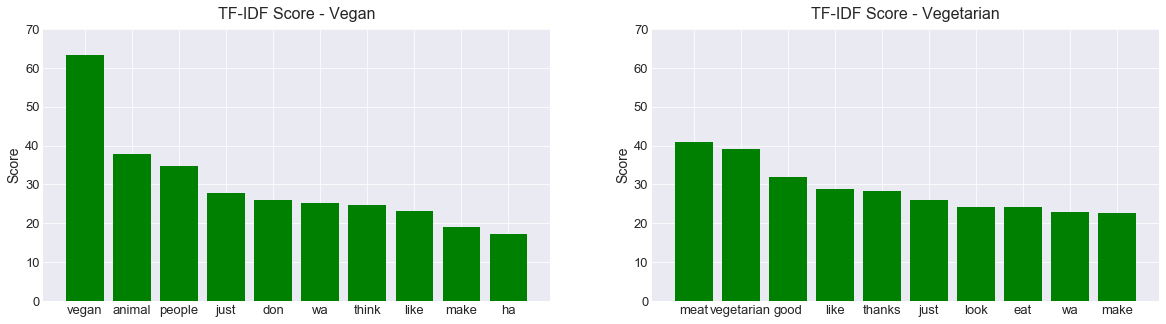

In [157]:
# Plot Most Common Words (Lemmatizer)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].bar(vegan_lemma.index, height=vegan_lemma['word_count_lemma'], color='green')
axes[0].set_title('TF-IDF Score - Vegan', size=16, pad=10)
axes[0].set_ylabel('Score', size=14)
axes[0].tick_params(labelsize=13)
axes[0].set_ylim(0,70)

axes[1].bar(vegetarian_lemma.index, height=vegetarian_lemma['word_count_lemma'], color='green')
axes[1].set_title('TF-IDF Score - Vegetarian', size=16, pad=10)
axes[1].set_ylabel('Score', size=14)
axes[1].tick_params(labelsize=13)
axes[1].set_ylim(0,70);